<a href="https://colab.research.google.com/github/AmitSingh-Rajjput/Time-Series-Notebook/blob/main/Time_Series_Analysis_EX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/krishnaik06/ARIMA-And-Seasonal-ARIMA/master/perrin-freres-monthly-champagne-.csv')
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [3]:
## Cleaning up the data
df.columns=["Month","Sales"]
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
## Drop last 2 rows
df.drop(106,axis=0,inplace=True)
df.drop(105,axis=0,inplace=True)

In [5]:
df.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [7]:
# Convert Month into Datetime
df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


**Visualize the data**

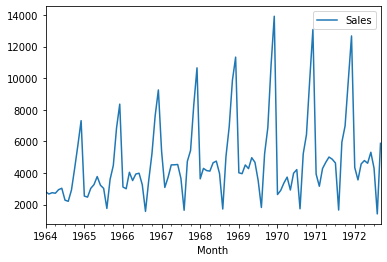

In [8]:
df.plot()

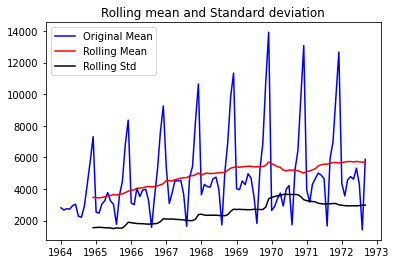

In [10]:
#Test for stationarity
rolmean=df.rolling(window=12).mean()
rolstd=df.rolling(window=12).std()
#plot rolling statitics
plt.plot(df,color='blue',label='Original Mean')
plt.plot(rolmean,color='red',label='Rolling Mean')
plt.plot(rolstd,color='black',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling mean and Standard deviation')
plt.show()

In [12]:
# Now we do Dicky-Fuller test
from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276228
p-value : 0.363915771660245
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**From this we know that our dataset is not stationary .So,To make them stationary we take differencing.**

In [15]:
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12) # shift 12 means in one year pattern will reapeat it self.
df.head(14)

,Sales,Seasonal First Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,NaN
1964-03-01,2755.0,NaN
1964-04-01,2721.0,NaN
1964-05-01,2946.0,NaN
1964-06-01,3036.0,NaN
1964-07-01,2282.0,NaN
1964-08-01,2212.0,NaN
1964-09-01,2922.0,NaN


In [16]:
## Again test dickey fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


**Now we can say that our data is stationary.**

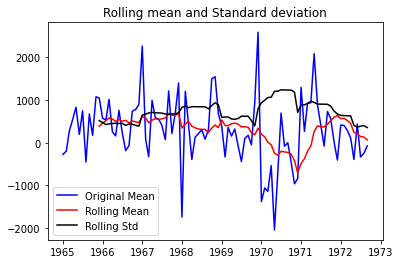

In [19]:
rolmean=df['Seasonal First Difference'].rolling(window=12).mean()
rolstd=df['Seasonal First Difference'].rolling(window=12).std()
#plot rolling statitics
plt.plot(df['Seasonal First Difference'],color='blue',label='Original Mean')
plt.plot(rolmean,color='red',label='Rolling Mean')
plt.plot(rolstd,color='black',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling mean and Standard deviation')
plt.show()

**Implementing ARIMA model
  
  For that we know about p,q,d value we know d=1 .For p and q value we can plot acf and pacf plot.**

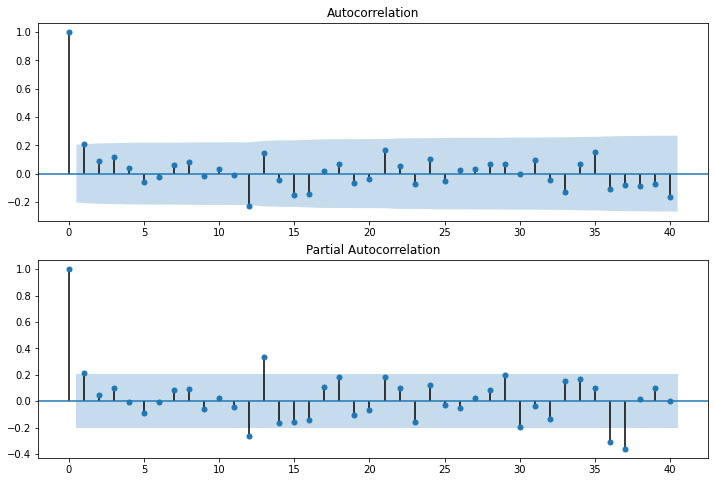

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

**From here we can say that p=1 and q=1 is the best value.**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


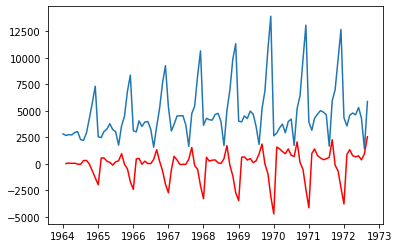

In [26]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df['Sales'],order=(1,1,1))
model_fit=model.fit()
plt.plot(df['Sales'])
plt.plot(model_fit.fittedvalues,color='red')
#plt.title('RSS :{}'.format(sum(result_ARIMA.fittedvalues-datasetLogDiffShift['#Passengers'])**2 ))

**Here we use ARIMA so it can't predict correctly because dataset is seasonal .so,we use SARIMA model.**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


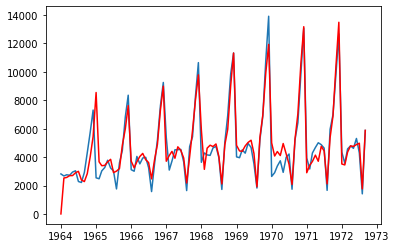

In [27]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
plt.plot(df['Sales'])
plt.plot(results.fittedvalues,color='red')

**We can say that this prediction is far better than previous one.**

In [29]:
df.shape

(105, 2)

**Now Add some future dates in dataset**

In [32]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [33]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [34]:
future_datest_df.tail()

,Sales,Seasonal First Difference
1974-04-01,NaN,NaN
1974-05-01,NaN,NaN
1974-06-01,NaN,NaN
1974-07-01,NaN,NaN
1974-08-01,NaN,NaN


In [35]:
future_df=pd.concat([df,future_datest_df])

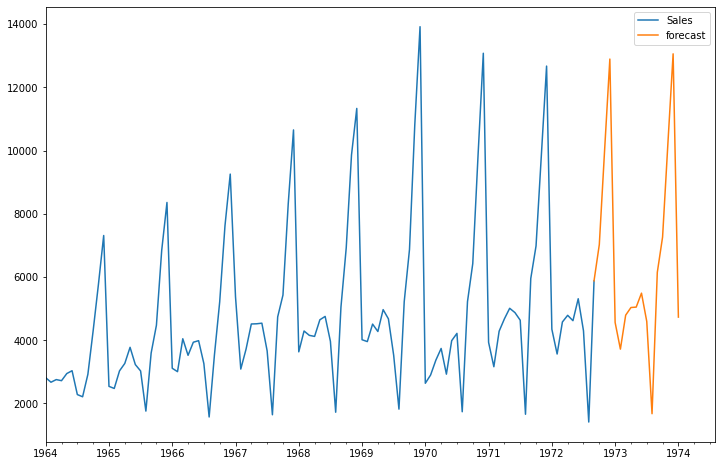

In [36]:
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))